# **Explainability Agent – SHAP**

This notebook demonstrates how to implement the SHAP Agent for the Popper framework. The goal is to generate local and global feature importance explanations for different machine learning models and compare them systematically.

## 1. Install Dependencies

We install and pin specific versions of SHAP, scikit-learn, XGBoost, LightGBM, pandas, numpy, and matplotlib. Pinning ensures reproducibility, since SHAP’s API often changes.

In [17]:

!pip -q install shap xgboost lightgbm scikit-learn matplotlib numpy pandas


In [18]:
!pip -q install -U shap


In [19]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
shap.initjs()

# Reproducibility
np.random.seed(42)


## 2) Load a dataset & Train/Test Split

We use the Breast Cancer dataset from sklearn.datasets. It is a standard classification dataset with numerical features, ideal for demonstrating SHAP explanations.

We split the data into training and testing subsets. The training data is used to fit the models, while the test set is used to evaluate performance and generate SHAP explanations.


In [20]:
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()

# X, y
X = df.drop(columns=[data.target_names[0] if data.target_names[0] in df.columns else 'target'])
y = data.target

feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, len(feature_names)


((426, 30), (143, 30), 30)

## 3) Define the SHAP Agent

Here we implement the SHAPAgent class, which encapsulates:

- Creating SHAP explainers for different model types (tree models, logistic regression, pipelines, etc.)

- Handling SHAP API differences (TreeExplainer, LinearExplainer, new Explainer APIs).

- Providing methods for:

  - Global explanations (summary plots, bar charts)

  - Local explanations (force plots, waterfall plots for individual predictions)

  - Interaction explanations (pairwise feature effects for tree models)

  - Cross-model comparison (comparing average feature importance across models)

This agent serves as the Explainability component of the Popper framework.

In [21]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from shap import maskers

class SHAPAgent:
    """
    SHAP Agent (robust, masker-ready)
    - Global/local explanations, interaction values (tree), cross-model comparison
    - Uses maskers.Independent for LinearExplainer
    - Handles SHAP API differences via a _shap_values() wrapper
    """

    def __init__(self, task_type="classification"):
        self.task_type = task_type
        self.explainers = {}        # model_name -> explainer
        self.backgrounds = {}       # model_name -> background used (post-transform for pipelines)
        self.preprocessors = {}     # model_name -> preprocessor (pipeline without final estimator) if any

    # ----- helpers -----
    def _is_tree_model(self, model):
        name = model.__class__.__name__.lower()
        return any(k in name for k in ["xgb", "lgbm", "randomforest", "decisiontree", "gradientboost"])

    def _is_lr_pipeline(self, model):
        if not isinstance(model, Pipeline):
            return False
        clf = model.named_steps.get("clf", None)
        return isinstance(clf, LogisticRegression)

    def _get_preprocessor(self, model):
        return model[:-1] if isinstance(model, Pipeline) else None

    def _maybe_transform(self, model_name, X):
        pre = self.preprocessors.get(model_name)
        return pre.transform(X) if pre is not None else X

    def _background_sample(self, X, n=100):
        try:
            return shap.sample(X, n) if len(X) > n else X
        except Exception:
            if isinstance(X, np.ndarray) and X.shape[0] > n:
                idx = np.random.RandomState(42).choice(X.shape[0], size=n, replace=False)
                return X[idx]
            return X

    def _shap_values(self, explainer, X_in):
        """Compatibility wrapper:
        - New explainers: explainer(X) -> Explanation
        - Legacy explainers: .shap_values(X[, check_additivity])
        """
        # New-style callable
        try:
            if callable(explainer) and not hasattr(explainer, "shap_values"):
                exp = explainer(X_in)
                if hasattr(exp, "values"):
                    return exp.values
        except Exception:
            pass
        # Legacy method with/without check_additivity
        if hasattr(explainer, "shap_values"):
            try:
                return explainer.shap_values(X_in, check_additivity=False)
            except TypeError:
                return explainer.shap_values(X_in)
        # Fallback
        exp = explainer(X_in)
        return getattr(exp, "values", exp)

    # ----- explainer setup -----
    def _make_explainer(self, model, model_name, X_background):
        X_bg = self._background_sample(X_background, 100)

        # Tree models -> TreeExplainer
        if self._is_tree_model(model):
            explainer = shap.TreeExplainer(model)
            self.explainers[model_name] = explainer
            self.backgrounds[model_name] = X_bg
            self.preprocessors[model_name] = None
            return explainer

        # LogisticRegression in Pipeline
        if self._is_lr_pipeline(model):
            pre = self._get_preprocessor(model)
            X_bg_t = pre.transform(X_bg)
            lr = model.named_steps["clf"]
            m = maskers.Independent(X_bg_t)
            explainer = shap.LinearExplainer(lr, m)
            self.explainers[model_name] = explainer
            self.backgrounds[model_name] = X_bg_t
            self.preprocessors[model_name] = pre
            return explainer

        # Plain LogisticRegression
        if isinstance(model, LogisticRegression):
            m = maskers.Independent(X_bg)
            explainer = shap.LinearExplainer(model, m)
            self.explainers[model_name] = explainer
            self.backgrounds[model_name] = X_bg
            self.preprocessors[model_name] = None
            return explainer

        # Generic fallback
        if self.task_type == "classification":
            predict_fn = getattr(model, "predict_proba", None) or getattr(model, "predict", None)
        else:
            predict_fn = getattr(model, "predict", None)
        m = maskers.Independent(X_bg)
        explainer = shap.Explainer(predict_fn, m, feature_names=getattr(X_bg, "columns", None))
        self.explainers[model_name] = explainer
        self.backgrounds[model_name] = X_bg
        self.preprocessors[model_name] = None
        return explainer

    # ----- global -----
    def explain_global(self, model, model_name, X, feature_names=None, max_display=12):
        if model_name not in self.explainers:
            self._make_explainer(model, model_name, X_background=X)

        explainer = self.explainers[model_name]
        X_in = self._maybe_transform(model_name, X)

        sv = self._shap_values(explainer, X_in)
        if isinstance(sv, list):  # multiclass legacy
            sv = sv[1] if len(sv) > 1 else sv[0]

        shap.summary_plot(sv, X, feature_names=feature_names, show=True, max_display=max_display)
        shap.summary_plot(sv, X, feature_names=feature_names, plot_type="bar", show=True, max_display=max_display)
        return sv

    # ----- local -----
    def explain_local(self, model, model_name, X, index=0, feature_names=None):
        if model_name not in self.explainers:
            self._make_explainer(model, model_name, X_background=X)

        explainer = self.explainers[model_name]
        x_row = X.iloc[[index]] if isinstance(X, pd.DataFrame) else X[index:index+1]
        x_in = self._maybe_transform(model_name, x_row)

        sv_row = self._shap_values(explainer, x_in)
        if isinstance(sv_row, list):
            sv_row = sv_row[1] if len(sv_row) > 1 else sv_row[0]

        base_value = getattr(explainer, "expected_value", None)
        if isinstance(base_value, (list, np.ndarray)):
            base = base_value[1] if len(np.atleast_1d(base_value)) > 1 else base_value[0]
        else:
            base = base_value

        display(shap.force_plot(base, sv_row[0], x_row, feature_names=feature_names))
        try:
            shap.plots._waterfall.waterfall_legacy(base, sv_row[0], feature_names=feature_names)
        except Exception:
            shap.plots.waterfall(
                shap.Explanation(values=sv_row[0], base_values=base,
                                 data=np.array(x_row)[0], feature_names=feature_names)
            )

    # ----- interactions (tree only) -----
    def explain_interactions(self, model, model_name, X, feature_names=None, max_display=10):
        if model_name not in self.explainers:
            self._make_explainer(model, model_name, X_background=X)
        explainer = self.explainers[model_name]

        if not isinstance(explainer, shap.explainers._tree.TreeExplainer):
            print("Interaction values require a TreeExplainer (tree-based model). Skipping.")
            return None

        X_in = self._maybe_transform(model_name, X)
        interaction_values = explainer.shap_interaction_values(X_in)
        if isinstance(interaction_values, list):
            interaction_values = interaction_values[1] if len(interaction_values) > 1 else interaction_values[0]

        shap.summary_plot(interaction_values, X, feature_names=feature_names, max_display=max_display)
        return interaction_values

    # ----- cross-model comparison -----
    def compare_models(self, models, X, y=None, feature_names=None, top_k=10):
      """
      Compare mean(|SHAP|) across trained models on the same dataset.
      Uses an OUTER merge (union of features) + fills missing with 0,
      so models with slightly different feature sets still compare.
      """
      import pandas as pd
      import numpy as np
      import matplotlib.pyplot as plt

      def _sv_to_array(explainer, X_in):
          sv = self._shap_values(explainer, X_in)
          if isinstance(sv, list):                  # LightGBM/binary or multiclass -> pick positive/last
              sv = sv[1] if len(sv) > 1 else sv[0]
          return np.asarray(sv)                     # (n_samples, n_features)

      def _derive_feature_names(base_X, n_features, provided_names):
          if isinstance(base_X, pd.DataFrame) and base_X.shape[1] == n_features:
              return list(base_X.columns)
          if provided_names is not None and len(provided_names) == n_features:
              return list(provided_names)
          return [f"f{i}" for i in range(n_features)]

      per_model_frames = []
      for model, name in models:
          if name not in self.explainers:
              self._make_explainer(model, name, X_background=X)

          explainer = self.explainers[name]
          X_in = self._maybe_transform(name, X)
          sv = _sv_to_array(explainer, X_in)             # (n_samples, n_features)
          mean_abs = np.abs(sv).mean(axis=0).reshape(-1) # (n_features,)
          n_feat = int(mean_abs.shape[0])

          fnames = _derive_feature_names(X, n_feat, feature_names)
          if len(fnames) != len(mean_abs):
              # last-resort: regenerate names to exact length
              fnames = [f"f{i}" for i in range(len(mean_abs))]

          per_model_frames.append(pd.DataFrame({
              "feature": fnames,
              f"mean|SHAP|_{name}": mean_abs
          }))

      # OUTER merge on feature name (union), then fill missing with 0
      merged = per_model_frames[0]
      for df in per_model_frames[1:]:
          merged = merged.merge(df, on="feature", how="outer")

      value_cols = [c for c in merged.columns if c.startswith("mean|SHAP|_")]

      if not value_cols:
          raise ValueError("No model columns found to compare. Check that models list is not empty.")

      merged[value_cols] = merged[value_cols].fillna(0.0)

      # Average importance across available models
      merged["avg"] = merged[value_cols].mean(axis=1)

      # Guard against empty result
      if merged.shape[0] == 0:
          print("No features available after alignment. Ensure all models were explained on the same X.")
          return merged

      out = merged.sort_values("avg", ascending=False).head(top_k).drop(columns=["avg"]).reset_index(drop=True)

      # Display table and plot
      display(out)

      if out.shape[0] == 0:
          print("No rows to plot after alignment (union produced 0 rows).")
          return out

      ax = out.plot(x="feature", kind="bar", figsize=(12, 6))
      ax.set_ylabel("mean(|SHAP value|)")
      ax.set_title("Cross-Model Feature Importance (mean |SHAP|)")
      plt.xticks(rotation=45, ha="right")
      plt.tight_layout()
      plt.show()
      return out



## 4) Instantiate Agent & Train Models

We create an instance of SHAPAgent and train four different models:

- XGBoost Classifier

- LightGBM Classifier

- Random Forest Classifier

- Logistic Regression (with scaling in a pipeline)

Each model is trained on the training set and evaluated with accuracy on the test set.

In [22]:
agent = SHAPAgent(task_type="classification")

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    objective="binary:logistic", eval_metric="logloss",
    random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=400, num_leaves=31, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
lgb_model.fit(X_train, y_train)

# RandomForest
rf_model = RandomForestClassifier(
    n_estimators=500, max_depth=None, min_samples_split=2,
    min_samples_leaf=1, random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Logistic Regression (pipeline with scaling)
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])
log_model.fit(X_train, y_train)

models = [
    (xgb_model, "XGBoost"),
    (lgb_model, "LightGBM"),
    (rf_model,  "RandomForest"),
    (log_model, "LogReg")
]

# quick sanity metrics
for m, n in models:
    if hasattr(m, "predict_proba"):
        preds = (m.predict_proba(X_test)[:,1] > 0.5).astype(int)
    else:
        preds = m.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{n:<12} | Accuracy: {acc:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 267, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626761 -> initscore=0.518344
[LightGBM] [Info] Start training from score 0.518344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## 5) Global explanations
We use SHAP to compute global feature importance:

- Summary dot plot shows how each feature impacts predictions across the dataset.

- Bar plot ranks features by their average contribution magnitude.

/tmp/ipython-input-879509697.py:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X, feature_names=feature_names, show=True, max_display=max_display)


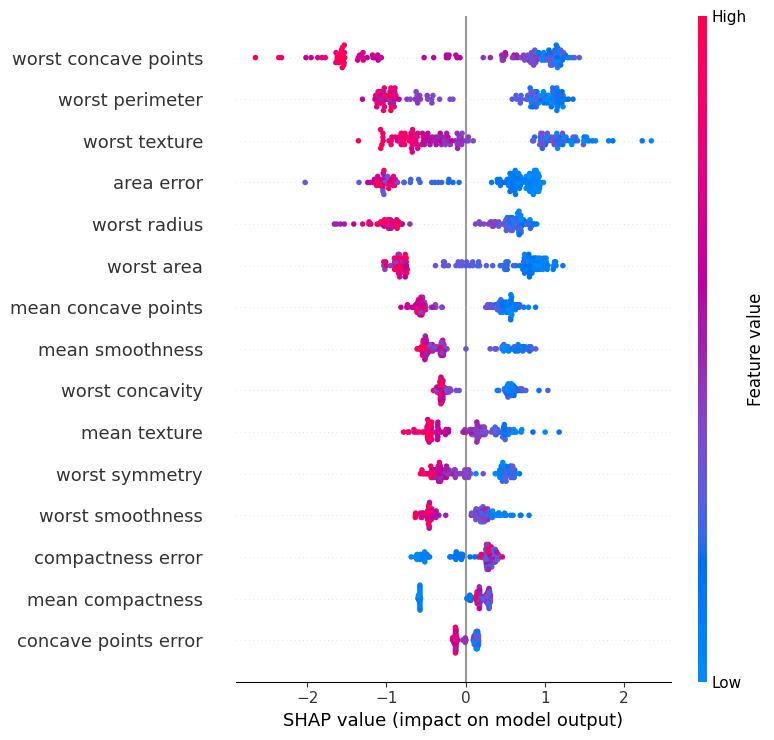

/tmp/ipython-input-879509697.py:132: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X, feature_names=feature_names, plot_type="bar", show=True, max_display=max_display)


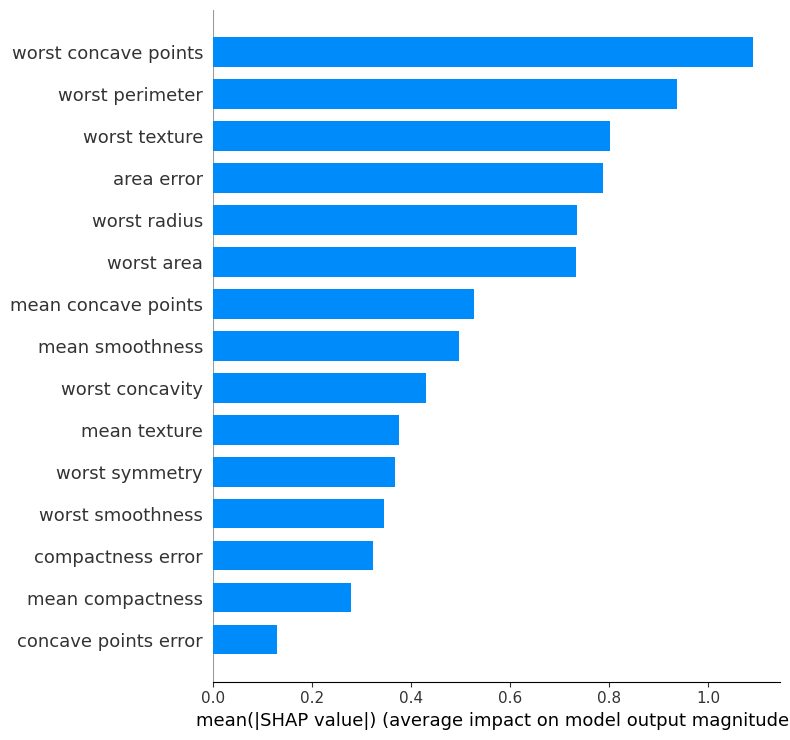

/tmp/ipython-input-879509697.py:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X, feature_names=feature_names, show=True, max_display=max_display)


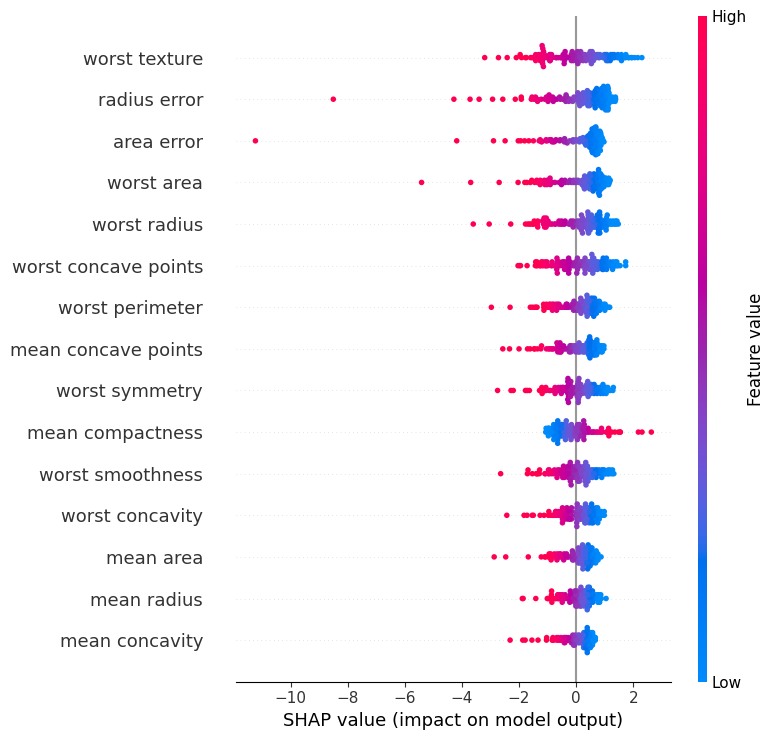

/tmp/ipython-input-879509697.py:132: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X, feature_names=feature_names, plot_type="bar", show=True, max_display=max_display)


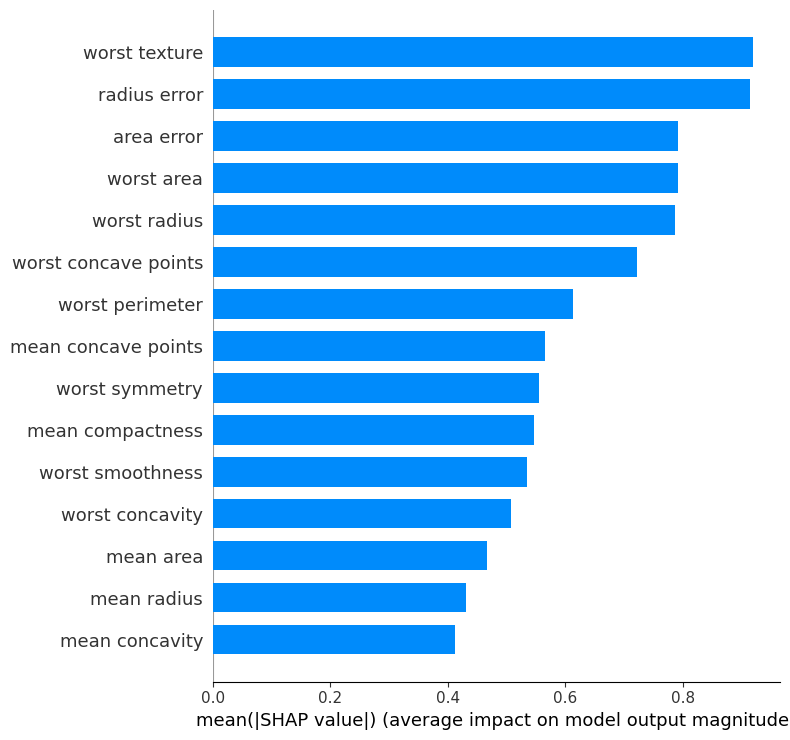

In [23]:

_ = agent.explain_global(xgb_model, "XGBoost", X_test, feature_names=feature_names, max_display=15)
_ = agent.explain_global(log_model, "LogReg", X_test, feature_names=feature_names, max_display=15)


## 6) Local explanations
We generate local explanations for a single prediction.

- Force plots show how features push the prediction away from the base value.

- Waterfall plots give a step-by-step breakdown of the feature contributions for one sample.



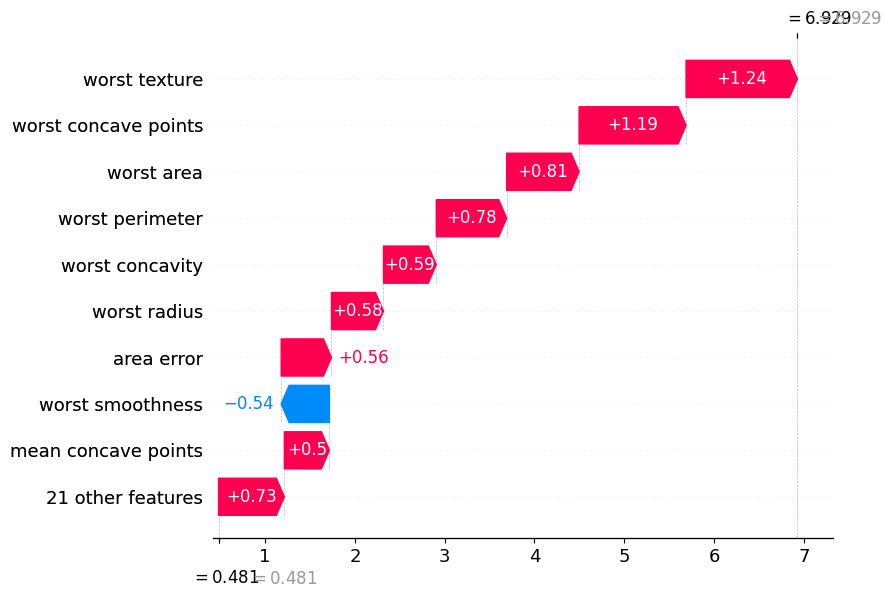

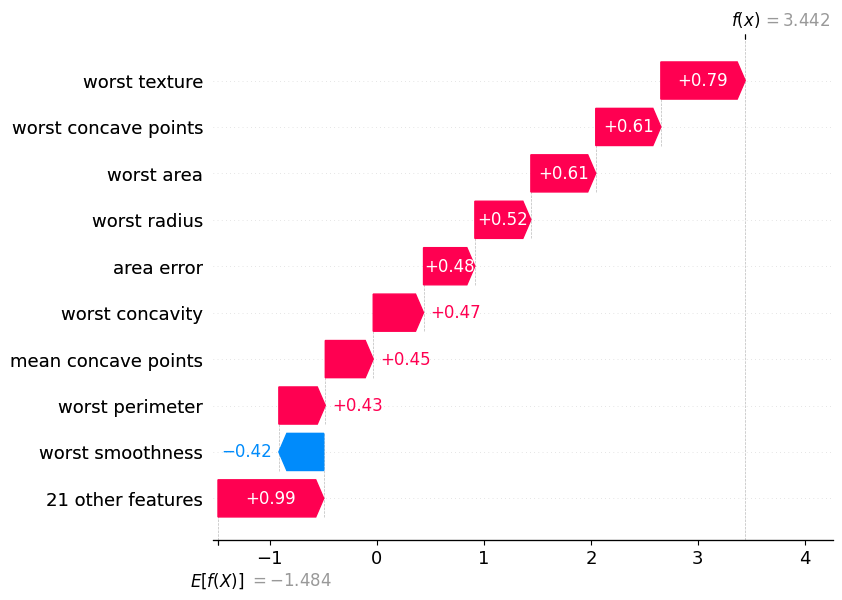

In [24]:
row_index = 0  # tweak to inspect other rows

agent.explain_local(xgb_model, "XGBoost", X_test, index=row_index, feature_names=feature_names)
agent.explain_local(log_model, "LogReg",   X_test, index=row_index, feature_names=feature_names)


## 7) Interaction Explanations (Tree Models Only)

For tree-based models (XGBoost, LightGBM, RandomForest), we compute interaction values, which show how pairs of features combine to influence predictions.

/tmp/ipython-input-879509697.py:178: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(interaction_values, X, feature_names=feature_names, max_display=max_display)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/pytho

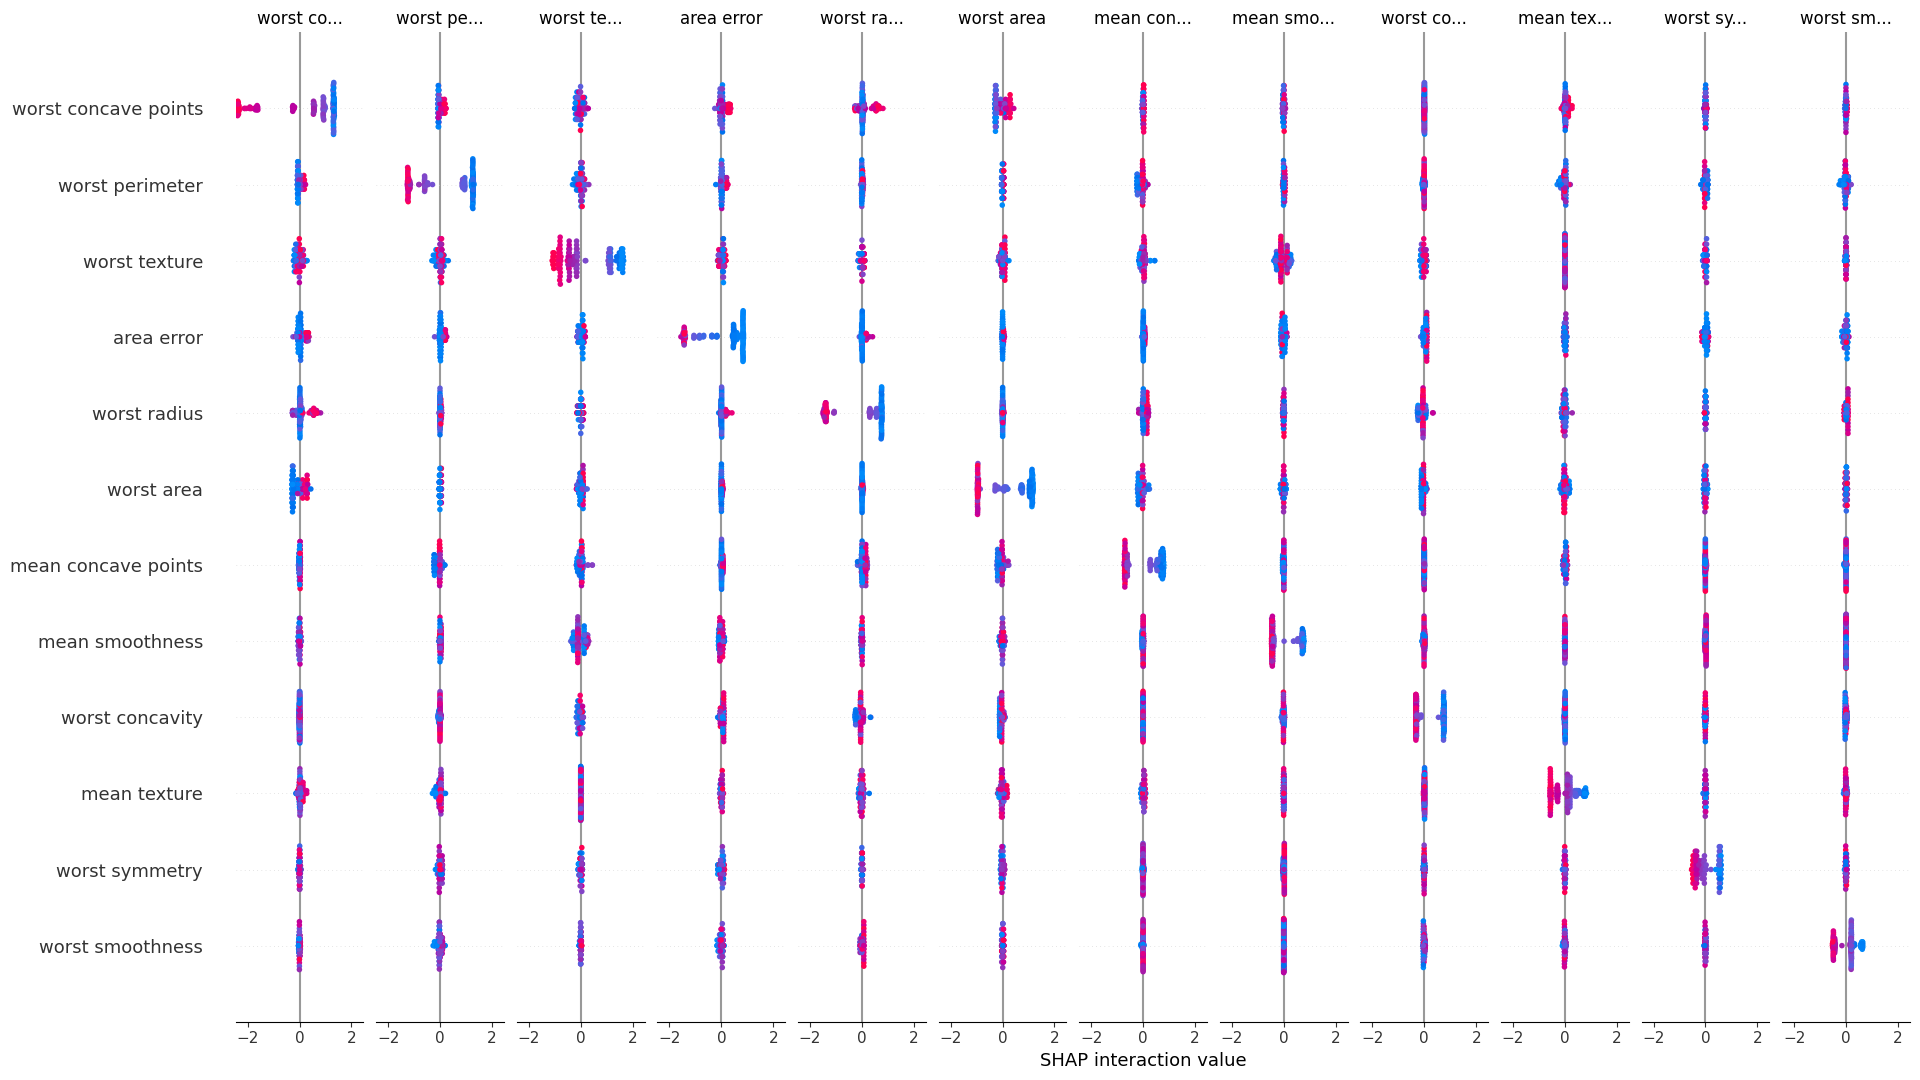

In [25]:
_ = agent.explain_interactions(xgb_model, "XGBoost", X_test, feature_names=feature_names, max_display=12)


## 8) Cross-model comparison (mean |SHAP|)
We compare feature importances across all trained models:

- Each model’s SHAP values are averaged across the test set.

- A merged table and bar plot show which features consistently matter across models.

- This step demonstrates the Popper philosophy of corroborating evidence: do models agree on which features are important?

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean|SHAP|_XGBoost,mean|SHAP|_LightGBM,mean|SHAP|_RandomForest,mean|SHAP|_LogReg
0,worst perimeter,0.936722,3.178738,0.0,0.612477
1,worst concave points,1.090731,1.973498,0.0,0.721880
2,worst area,0.732850,1.638816,0.0,0.791113
3,worst texture,0.801576,1.309112,0.0,0.919263
4,area error,0.787483,0.867719,0.0,0.791864
5,worst radius,0.735098,0.888172,0.0,0.786250
6,mean concave points,0.528477,1.315980,0.0,0.564699
7,worst smoothness,0.345822,0.863189,0.0,0.534806
8,worst concavity,0.431439,0.798336,0.0,0.507884
9,worst symmetry,0.367727,0.556728,0.0,0.555628


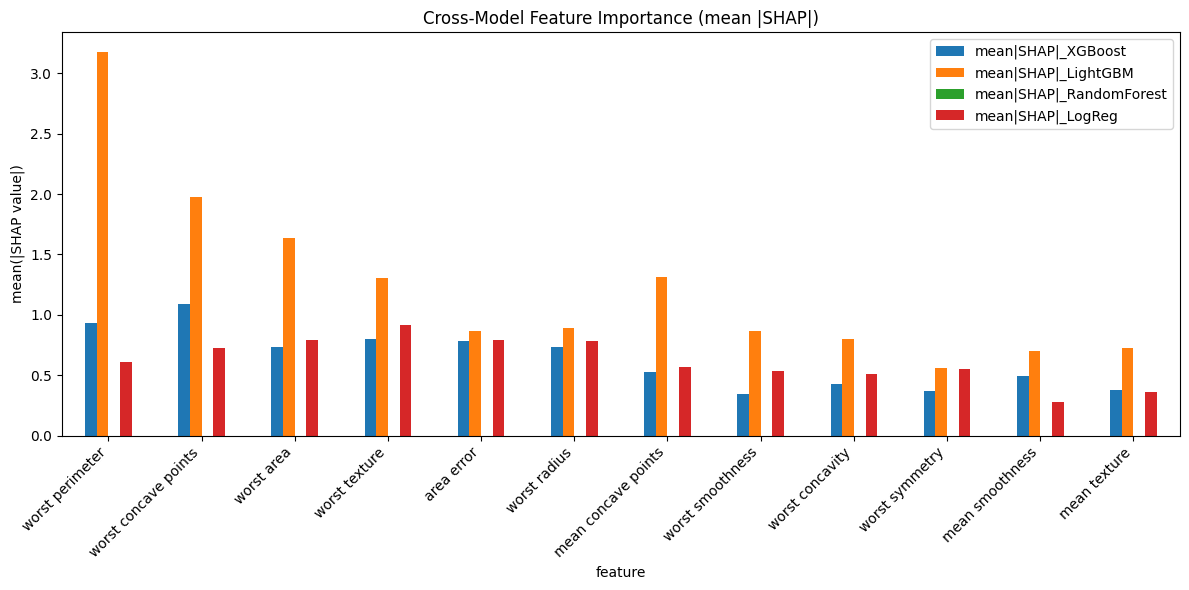

In [26]:
_ = agent.compare_models(models, X_test, y_test, feature_names=feature_names, top_k=12)
